eecs545 --hw3   
Author: Zijin Zhang

### problem1 --Linear Regression 

In [882]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
########################################################################
# Data loading
########################################################################
np.random.seed(5)  # seed the random number generator
bodyfat = sio.loadmat('bodyfat_data.mat')

x = bodyfat['X']
y = bodyfat['y']

# split into train and test with seeded randomization
train_idx = np.random.choice(np.arange(x.shape[0]), 150, replace=False)
test_idx = list(set(np.arange(x.shape[0])) - set(train_idx))
x_train = x[train_idx, :]
y_train = y[train_idx]
x_test = x[test_idx, :]
y_test = y[test_idx]

x_mean = np.mean(x_train, axis=0)
y_mean = np.mean(y_train)
# demean: eliminate b
x_train = x_train - np.mean(x_train, axis=0)
y_train = y_train - np.mean(y_train, axis=0)

In [883]:
########################################################################
# Least squares regression (TODO)
########################################################################
"""
We did all the data loading and plotting for you. You just have to write
the code for regression.
Save your learned parameters into two separate variables, w_ols and b_ols.
w_ols should have shape (2, 1) and b_ols should have shape (1,). Make sure
your variables have these shapes, or else plotting may not work.
"""

LAMBDA = 10
def linear_model(w, x):
    '''Linear model y = w^Tx + b'''
    return np.sum(x.dot(w),axis=1).reshape((248,1))
def obj_function(w, x, y):
    '''Objective function for ridge regression with λ=10'''
    n = len(y)
    A = 2*(x.T.dot(x) + n*10*np.eye(2))
    r = -2*x.T.dot(y)
    c = y.T.dot(y)
    return 1/2 * w.T.dot(A).dot(w) + r.T.dot(w) + c
def calc_w(x, y):
    '''Calculate for w'''
    n = len(y)
    A = 2*(x.T.dot(x) + n*LAMBDA*np.eye(2))
    r = -2 * x.T.dot(y)
    w_ols = -np.linalg.inv(A).dot(r)
    return w_ols

w_ols = calc_w(x_train, y_train)

# Calculate b_ols using w_ols and mean value of x and y
b_ols = y_mean - w_ols.T.dot(x_mean)
print('w_ols:\n', w_ols)
print('b_ols:\n', b_ols)

w_ols:
 [[0.58936505]
 [0.0847982 ]]
b_ols:
 [-43.84139358]


In [884]:
# Calculate test error using Mean square error
MSE = np.square(y_test - x_test.dot(w_ols) - b_ols).sum()/len(y_test)
print('MSE:', MSE)
x_predict = 100*w_ols[0] + 100*w_ols[1] + b_ols
predict_point = np.array([100, 100])
predict = (w_ols.T.dot(predict_point) + b_ols)[0]
print('So, the predicted value for the point [100, 100] should be {}'.format(round(predict,6)))

MSE: 24.119403580191786
So, the predicted value for the point [100, 100] should be 23.574931


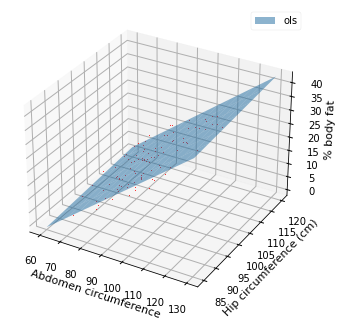

In [885]:
########################################################################
# Plotting data points and learned hyperplanes
########################################################################
plt3d = plt.figure()
ax = plt3d.add_subplot(111, projection='3d')
xx, yy = np.meshgrid(np.linspace(60, 130, 14), np.linspace(85, 120, 7))
pts = np.array([xx.ravel(), yy.ravel()]).T

# data points
ax.plot(x_test[:, 0], x_test[:, 1], y_test[:, 0], color='red', marker='o', markersize=1, linestyle='None')

# OLS hyperplane
ols_pred = pts.dot(w_ols) + b_ols
ols_surf = ax.plot_surface(xx, yy, ols_pred.reshape(xx.shape), alpha=0.5, label='ols')

# fixing bug with plot_surface and legend
ols_surf._facecolors2d = ols_surf._facecolors3d
ols_surf._edgecolors2d = ols_surf._edgecolors3d

# set axis labels and legend
ax.set(xlabel='Abdomen circumference', ylabel='Hip circumference (cm)', zlabel='% body fat')
ax.legend(loc='upper right')

plt.show()

### problem3 --Gradient Descent

In [902]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import random
np.random.seed(0)
random.randint(0,20000)
nuclear = sio.loadmat('nuclear.mat')

x = nuclear['x']
y = nuclear['y']
print(x.shape, y.shape)

negInd = y == -1
posInd = y == 1
plt.scatter(x[0, negInd[0, :]], x[1, negInd[0, :]], color='b')
plt.scatter(x[0, posInd[0, :]], x[1, posInd[0, :]], color='r')
plt.figure(1)
plt.show()
# Insert [1, 1, ... , 1] into the first row of x
x = np.r_[np.array([[1] * 20000]), x]
# Calculate for x_transpose for convinience
x = x.T

(2, 20000) (1, 20000)


### Question 3(b) --Subgradient Descent method

In [903]:
# Define some constants
n = len(x)
d = len(x[0])
I = np.diag(np.ones(d))
I[0,0] = 0
LAMBDA = 0.001

In [904]:
def gradient_t(theta, x, y):
    '''Calculate gradient of theta'''
    sum_term = 0
    I = np.diag(np.ones(3))
    I[0, 0] = 0
    for i in range(n):
        # Here use tmp as an indicator
        if y[0][i] * theta.dot(x[i].T) <= 1:
            tmp = 1
        else:
            tmp = 0
        sum_term += -y[0][i] * tmp * x[i]
    gradient_theta = sum_term/n + LAMBDA * I.dot(theta)
    return gradient_theta

In [905]:
def objective_function(theta, x, y):
    '''Calculate objective at theta'''
    sum_term = 0
    for i in range(n):
        sum_term += np.maximum(0, 1 - y[0][i] * theta.dot(x[i].T))
    objective = sum_term / n + LAMBDA / 2 * theta.dot(I.dot(theta.T))
    return objective

In [906]:
def iterate_subgradient(theta, x, y, times):
    alpha = 3
    objectives = []
    for i in range(times):
        alpha = 100 / (i+1)   # step-size
        objective = objective_function(theta, x, y)
        objectives.append(objective)
        gradient = gradient_t(theta, x, y)
        theta = theta - alpha * gradient
        print('theta:', theta, '        objective:', objective)
    return theta, objectives

# Initialize theta and number of iterations
theta = np.zeros((3,))
# Here I apply 40 as the number of iterations since after "eyeballing", I think 40 iterations 
# are good ennough for the objective to be relatively stable
theta_subgradient, objectives_subgradient = iterate_subgradient(theta, x, y, 40)

theta: [ 0.          7.12727977 12.47936953]         objective: 1.0
theta: [-25.        -22.997598    6.4621813]         objective: 6.19271655127375
theta: [-8.33333333e+00 -9.57562552e-03  1.40020449e+01]         objective: 27.113035291658917
theta: [ 0.47291667  5.33448136 16.40719171]         objective: 1.9372059673034356
theta: [-9.52708333 -6.67961377 13.92175998]         objective: 5.831028094536571
theta: [-1.19375     4.54243101 17.56736548]         objective: 6.596666150990846
theta: [-8.26589286 -4.0107594  15.7783956 ]         objective: 4.668944613767002
theta: [-2.01589286  4.37241351 18.48939178]         objective: 3.7682419923976855
theta: [-7.42144841 -2.25116296 17.09360014]         objective: 4.279232158833751
theta: [-3.02844841  2.76951647 18.6802065 ]         objective: 1.9741681136682476
theta: [-6.33981205 -2.31488661 17.60279392]         objective: 2.9211665348369595
theta: [-3.09606205  0.91022213 18.6101747 ]         objective: 1.4813786932548292
theta: [-5.06

**Comment:**  
After 40 iterations, estimated b, w1 and w2 for hyperplane are approximately -1.0195, -3.7327 and 18.4544, and the minimum achieved  
objective is approximately 0.35.

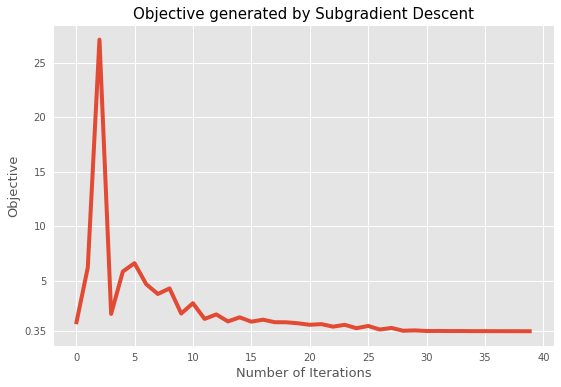

In [907]:
plt.style.use('ggplot')
plt.yticks([0.35, 5, 10, 15, 20, 25],['0.35','5','10','15','20','25'])
plt.title('Objective generated by Subgradient Descent', fontsize=15)
plt.xlabel('Number of Iterations', fontsize=13)
plt.ylabel('Objective', fontsize=13)
plt.plot(objectives_subgradient)

In [908]:
# Plot for learning line
negInd = y == -1
posInd = y == 1
plt.scatter(x.T[1, negInd[0, :]], x.T[2, negInd[0, :]], color='b')
plt.scatter(x.T[1, posInd[0, :]], x.T[2, posInd[0, :]], color='r')
plt.figure(1)

b, w1, w2 = theta_subgradient[0], theta_subgradient[1], theta_subgradient[2]
end_point1 = -((w1 * 0) + b) / w2
end_point2 = -((w1 * 7.5) + b) / w2
plt.plot([0,7.5], [end_point1, end_point2], color = 'darkslategrey', linewidth = 3)
plt.title('Learning Line', fontsize=15)
plt.show()

### Question 3(b) --Stochastic Gradient Descent method

In [909]:
def gredient_SGD(theta, x, y, i):
    '''The function is used to calculate the gradient of theta at data point (xi, yi)'''
    sum_term = 0
    I = np.diag(np.ones(3))
    I[0, 0] = 0
    if y[0][i] * theta.dot(x[i].T) <= 1:
        tmp = 1
    else:
        tmp = 0
    gradient = -1/n * y[0][i] * tmp * x[i] + 1/n * LAMBDA * I.dot(theta)
    return gradient

In [910]:
def iterate_SGD(theta, x, y, times):
    objectives = []
    for j in range(times):
        alpha = 100 / (j+1)  # step-size
        # For SGD, the objective function is the same as before
        objective = objective_function(theta, x, y)
        objectives.append(objective)
        for i in range(n):
            theta = theta - alpha * gredient_SGD(theta, x, y, i)
        print('theta:', theta, '        objective:', objective)
    return theta, objectives

In [911]:
theta = np.zeros((3,))
theta_SGD, objectives_SGD = iterate_SGD(theta, x, y, 40)

theta: [-0.98       -1.37665207  7.08933663]         objective: 1.0
theta: [-0.9675     -1.66194815  8.51580411]         objective: 0.38856803307612997
theta: [-0.95583333 -1.77621442  9.16378341]         objective: 0.336893740478327
theta: [-0.94333333 -1.85370579  9.55353491]         objective: 0.31983988762495263
theta: [-0.94233333 -1.90772734  9.81957354]         objective: 0.31240999746924564
theta: [-0.94066667 -1.94540722 10.01427106]         objective: 0.3084987850006781
theta: [-0.94066667 -1.97432728 10.16575661]         objective: 0.3059388077516326
theta: [-0.93941667 -1.99798597 10.28806349]         objective: 0.30416968506941383
theta: [-0.93830556 -2.01881275 10.39033206]         objective: 0.30286630930536523
theta: [-0.93780556 -2.03474288 10.47730856]         objective: 0.30187032461710683
theta: [-0.9382601  -2.05118861 10.55141713]         objective: 0.30107499074537847
theta: [-0.9370101  -2.0658154  10.61604989]         objective: 0.3004381626766238
theta: [-0.93

**Comment:**  
After 40 iterations (notice that all data points have been cycled through in each iterations), estimated b, w1 and w2 for hyperplane are  
approximately -0.9467, -2.2156 and 11.2922, and the minimum achieved objective is approximately 0.30.  

What should be noticed is that stochastic gradient uses the loss function of each sample to obtain the partial derivative of theta to obtain the  
corresponding gradient. SGD has a large number of iterations, and generally moves toward the optimal value. So, we could unnderstand the  
difference between SGD and subgradient as SGD is morely firstly searching for the best direction and then descent, but subgradient is more  
like descend while searching for direction. So SGD converges more quickly and smoothly, also end with lower objective.

Text(0.5, 1.0, 'Objective generated by Stochastic Gradient Descent')

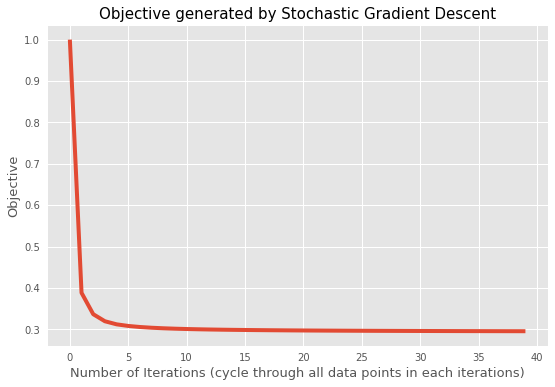

In [912]:
plt.plot(objectives_SGD)
plt.xlabel('Number of Iterations (cycle through all data points in each iterations)', fontsize=13)
plt.ylabel('Objective', fontsize=13)
plt.title('Objective generated by Stochastic Gradient Descent', fontsize=15)

In [913]:
# Plot for learning line
negInd = y == -1
posInd = y == 1
plt.scatter(x.T[1, negInd[0, :]], x.T[2, negInd[0, :]], color='b')
plt.scatter(x.T[1, posInd[0, :]], x.T[2, posInd[0, :]], color='r')
plt.figure(1)

b, w1, w2 = theta_SGD[0], theta_SGD[1], theta_SGD[2]
end_point1 = -((w1 * 0) + b) / w2
end_point2 = -((w1 * 7.5) + b) / w2
plt.plot([0,7.5], [end_point1, end_point2], color = 'darkslategrey', linewidth = 3)
plt.title('Learning Line', fontsize=15)
plt.show()